In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import datetime, os


#logs_base_dir = ".logs"
#os.makedirs(logs_base_dir, exist_ok = True)
#%tensorboard --logdir {logs_base_dir}

**Prediction of concrete strength based on composition of composition and statistical data based on RNN + LSTM**

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    #df_new['Date'] = df['Date']
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

#df = pd.read_csv("19880101_20161231.csv", index_col='Date')
#df = pd.read_csv('concrete.csv')


data = generate_features(df)

print(data.head(500))

In [ ]:
data = pd.read_csv('concrete.csv')

**Prediction of concrete strength based on composition of composition and statistical data based on RNN + LSTM**

In [ ]:
#print(data)
print(data)

      cement   slag    ash  water  ...  coarseagg  fineagg  age  strength
0      141.3  212.0    0.0  203.5  ...      971.8    748.5   28     29.89
1      168.9   42.2  124.3  158.3  ...     1080.8    796.2   14     23.51
2      250.0    0.0   95.7  187.4  ...      956.9    861.2   28     29.22
3      266.0  114.0    0.0  228.0  ...      932.0    670.0   28     45.85
4      154.8  183.4    0.0  193.3  ...     1047.4    696.7   28     18.29
...      ...    ...    ...    ...  ...        ...      ...  ...       ...
1025   135.0    0.0  166.0  180.0  ...      961.0    805.0   28     13.29
1026   531.3    0.0    0.0  141.8  ...      852.1    893.7    3     41.30
1027   276.4  116.0   90.3  179.6  ...      870.1    768.3   28     44.28
1028   342.0   38.0    0.0  228.0  ...      932.0    670.0  270     55.06
1029   540.0    0.0    0.0  173.0  ...     1125.0    613.0    7     52.61

[1030 rows x 9 columns]


In [ ]:
start_train = int(0)
end_train = int(773)

start_test = int(774)
end_test = int(1030)

In [ ]:
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('strength', axis=1).values
y_train = data_train['strength'].values


data_test = data.loc[start_test:end_test]
X_test = data_test.drop('strength', axis=1).values
y_test = data_test['strength'].values

In [ ]:
y_train

array([29.89, 23.51, 29.22, 45.85, 18.29, 21.86, 15.75, 36.64, 21.65,
       28.99, 36.35,  6.94, 27.92, 26.26, 23.89, 49.97, 30.08, 44.86,
       15.04, 25.1 , 13.36, 21.92, 20.42, 33.3 , 31.74, 45.3 , 49.19,
       65.2 , 21.54, 33.8 , 32.04, 39.29, 23.74, 44.52, 37.91, 39.16,
       16.88, 47.71, 17.54, 41.41, 24.28, 60.32, 37.42, 23.52, 59.2 ,
       61.46, 17.2 , 40.68, 49.9 , 33.4 , 49.25, 39.  , 37.27, 39.3 ,
       38.22, 20.28, 48.67, 34.57, 35.23, 42.35, 20.73, 10.38, 37.34,
       54.9 , 41.05, 29.98, 28.63, 44.3 , 52.04, 49.8 , 11.41, 50.46,
       28.1 , 26.92, 45.08, 36.94, 24.13, 19.42, 27.42, 39.15, 28.47,
       31.02, 31.25, 43.06, 12.84, 32.24, 67.57, 26.31, 35.3 , 23.8 ,
       14.59, 55.9 , 21.5 , 41.84,  4.9 , 57.23, 71.3 , 33.4 , 33.4 ,
       36.25, 32.96, 61.89, 36.8 , 53.1 , 11.98, 23.85,  9.74, 14.5 ,
       12.18, 38.63, 55.65, 12.05, 27.68, 31.35, 18.13, 12.79, 37.36,
       39.4 , 29.45, 33.36, 16.26, 39.64, 23.79, 45.94, 61.07, 31.03,
       33.19, 21.86,

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
#X_scaled_test

In [ ]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers

tf.random.set_seed(42)
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    #keras.layers.Dense(units=32, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1)
])

In [ ]:
model = tf.keras.models.load_model('keras_model.h5')

# Check its architecture
model.summary()

In [ ]:
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(0.07))

model.fit(X_scaled_train, y_train, epochs=100, verbose=True)

Epoch 1/100
25/25 [==============================] - 1s 2ms/step - loss: 423.2751
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 160.0874
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 207.8285
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 120.7326
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 78.1955
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 69.6479
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 75.9505
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 50.6774
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 41.9855
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 45.7637
Epoch 11/100
25/25 [==============================] - 0s 2ms/step - loss: 55.8692
Epoch 12/100
25/25 [==============================] - 0s 2ms/step - loss: 59.5942
Epoch 13/100
25/25 [=

In [ ]:
predictions1 = model.predict(X_scaled_test)[:, 0]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions1):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions1):.3f}')
print(f'R^2: {r2_score(y_test, predictions1):.3f}')

MSE: 32.167
MAE: 4.188
R^2: 0.878


In [ ]:
from tensorboard.plugins.hparams import api as hp
HP_HIDDEN = hp.HParam('hidden_size', hp.Discrete([64, 32, 16]))
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([300, 1000]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.01, 0.4))

In [ ]:
def train_test_model(hparams, logdir):
    model = keras.Sequential([
       keras.layers.Dense(units=hparams[HP_HIDDEN], activation='relu'),
       tf.keras.layers.Dropout(0.5),
       keras.layers.Dense(units=1)
    ])
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(hparams[HP_LEARNING_RATE]),
                  metrics=['mean_squared_error'])
    model.fit(X_scaled_train, y_train, validation_data=(X_scaled_test, y_test), epochs=hparams[HP_EPOCHS], verbose=False,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(logdir),  # log metrics
                  hp.KerasCallback(logdir, hparams),  # log hparams
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
                  )
              ],
              )
    _, mse = model.evaluate(X_scaled_test, y_test)
    pred = model.predict(X_scaled_test)
    r2 = r2_score(y_test, pred)
    return mse, r2

def run(hparams, logdir):
    with tf.summary.create_file_writer(logdir).as_default():
        hp.hparams_config(
            hparams=[HP_HIDDEN, HP_EPOCHS, HP_LEARNING_RATE],
            metrics=[hp.Metric('mean_squared_error', display_name='mse'),
                     hp.Metric('r2', display_name='r2')],
        )
        mse, r2 = train_test_model(hparams, logdir)
        tf.summary.scalar('mean_squared_error', mse, step=1)
        tf.summary.scalar('r2', r2, step=1)


session_num = 0

for hidden in HP_HIDDEN.domain.values:
    for epochs in HP_EPOCHS.domain.values:
        for learning_rate in tf.linspace(HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value, 5):
            hparams = {
                HP_HIDDEN: hidden,
                HP_EPOCHS: epochs,
                HP_LEARNING_RATE: float("%.2f"%float(learning_rate)),
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(hparams, 'logs/hparam_tuning/' + run_name)
            session_num += 1



--- Starting trial: run-0
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.01}
8/8 [==============================] - 0s 2ms/step - loss: 74.0200 - mean_squared_error: 74.0200
--- Starting trial: run-1
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.11}
8/8 [==============================] - 0s 2ms/step - loss: 109.0901 - mean_squared_error: 109.0901
--- Starting trial: run-2
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.21}
8/8 [==============================] - 0s 3ms/step - loss: 82.9389 - mean_squared_error: 82.9389
--- Starting trial: run-3
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.3}
8/8 [==============================] - 0s 2ms/step - loss: 96.4128 - mean_squared_error: 96.4128
--- Starting trial: run-4
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.4}
8/8 [==============================] - 0s 2ms/step - loss: 118.3920 - mean_squared_error: 118.3920
--- Starting trial: run-5
{'hidden_size': 16, 'epochs': 1000, 'learning_rate': 0.01}
8/8 [===

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    #keras.layers.Dense(units=16, activation='relu'),
    #keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.08))

model.fit(X_scaled_train, y_train, epochs=1000, verbose=False)

#

In [ ]:
predictions = model.predict(X_scaled_test)[:, 0]

In [ ]:
model.save('data_concrete/keras_model.h5')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

MSE: 43.642
MAE: 4.275
R^2: 0.835


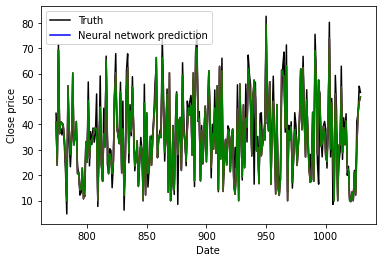

In [ ]:
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions, c='r')
plt.plot(data_test.index, predictions, c='g')
#plt.xticks(range(0, 252, 10), rotation=1)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction'])
plt.show()

In [ ]:
  #X_scaled_train

In [ ]:
print(predictions)

[40.86501  23.905247 69.29851  36.52488  41.043663 40.577755 39.402786
 33.97519  25.324493  9.974627 55.215538 38.473946 28.105799 34.108833
 60.284264 31.940243 35.441494 41.153896 20.561264 20.873852 14.102381
 14.575001 22.864536 10.710416 15.163099 33.270874 25.088299 49.424706
 26.695362 33.306362 33.80514  35.371124 38.027664 38.79833  37.635033
  9.974627 33.76033  46.85858  24.108883 17.751263 36.33127  31.13204
 65.43346  35.116825 20.602472 28.390057 26.631832 20.671408 25.466013
 50.975418 60.41104  39.14174  35.547653 32.43358  52.72637  20.929504
 38.225834 12.020216 25.739769 53.536568 62.430748 28.661346 45.350105
 37.1413   54.783165 38.70063  23.61851  25.662682 33.607777 15.759599
 27.33328  31.612839 29.504038  9.974627 48.52536  12.228101 44.54065
 20.760553 20.997932 35.326546 23.899708 33.932594 42.484406 48.60012
 66.34246  27.13222  35.261253 36.14942  34.822052 66.32504  46.481483
 28.967264 33.369835 51.85958  13.298391 60.36376   9.974627 16.63836
 39.206116

In [ ]:
y_test

array([44.4 , 24.5 , 71.62, 36.3 , 38.46, 35.86, 40.15, 31.42, 20.73,
        4.78, 46.23, 33.56, 23.35, 32.92, 41.37, 32.85, 35.08, 38.2 ,
       23.4 , 20.97, 12.18, 13.18, 19.01, 14.64, 11.58, 30.12, 26.06,
       56.74, 23.7 , 37.17, 32.11, 38.61, 33.02, 36.45, 52.01,  7.72,
       28.68, 59.09, 24.66, 17.57, 46.39, 31.27, 66.9 , 24.34, 20.87,
       30.44, 29.75, 15.09, 24.07, 52.44, 67.87, 39.09, 35.23, 38.56,
       56.61, 22.32, 49.2 ,  6.27, 25.69, 61.24, 67.8 , 24.89, 47.82,
       35.57, 58.8 , 35.1 , 21.75, 28.8 , 30.28, 15.58, 24.1 , 34.9 ,
       29.55, 14.4 , 55.83, 15.87, 43.01, 15.36, 22.63, 33.31, 34.77,
       36.3 , 44.52, 56.7 , 63.53, 26.85, 33.76, 37.33, 38.7 , 73.7 ,
       53.9 , 25.56, 37.17, 53.96, 21.29, 41.37, 10.09, 17.44, 39.61,
       12.46, 41.1 , 52.83,  8.54, 41.54, 38.41, 22.5 , 64.3 , 41.89,
       33.7 , 23.74, 49.2 , 44.13, 48.72, 51.43, 44.61, 57.92, 15.53,
       66.6 , 77.3 , 41.16, 45.08, 17.95, 39.6 , 24.4 , 34.56, 46.64,
       27.63, 41.93,